## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

#from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

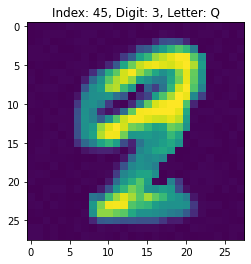

In [3]:
idx = 45
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## preprocessing (equalization,stretching)

열림,닫힘 연산도 진행할 수 있음

평활화와 스트레칭 모두 해보았는데, 스트레칭은 원본사진과 크게 변화가 없어 equalization된 사진으로 전처리를 하여 진행해봄

In [3]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1) 
#x_train = x_train/255 # data 정규화
#img=x_train[0].reshape(28,28).astype(int)

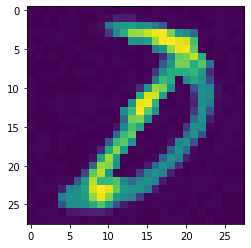

In [58]:
plt.imshow(x_train[3]) #원본

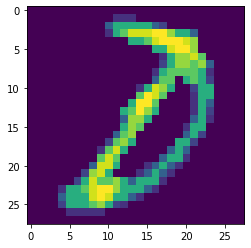

In [59]:
plt.imshow(X_train[3]) #equlization

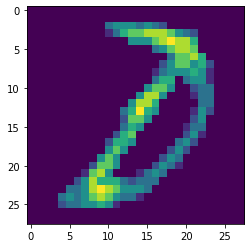

In [60]:
plt.imshow(x__train[3]) #stretching

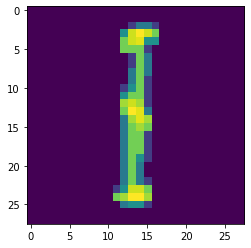

In [7]:
#equalization
X_train=[ eq(img) for img in x_train ]
plt.imshow(X_train[0])

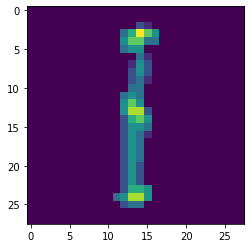

In [8]:
#stretching
x__train=[ stretch_img(img) for img in x_train]
plt.imshow(x__train[0])
#stretch_img(x_train[0]) 

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# img=x_train[0].reshape(28,28).astype(int)
# img1=np.uint8(cv2.normalize(img, None, 0, 8, cv2.NORM_MINMAX)) 
# plt.imshow(cv2.equalizeHist(img1),cmap=plt.cm.gray)

def eq(img):
    img=img.reshape(28,28).astype(int)
    img1=np.uint8(cv2.normalize(img, None, 0, 8, cv2.NORM_MINMAX)) 
    return cv2.equalizeHist(img1)

In [6]:
import numpy as np
#from PIL import Image

import matplotlib.pyplot as plt 

def stretch_img(img): #(2048,28,28,1) 반복문으로 넣음
    img=img.reshape(28,28).astype(int)
    #img=Image.fromarray(img)
    row = 28
    col = 28
    stretch_img = np.zeros((28,28))
    high = 0
    low = 8

    for x in range(1 , row):
        for y in range(1, col):
            if high < img[x,y] :
                high = img[x,y]
            if low > img[x,y]:
                low = img[x,y]
    for x in range(1 , row):
        for y in range(1, col):
            stretch_img[x,y]=int((img[x,y]-low)*8/(high-low))
   
    return stretch_img#스트레칭된 이미지 출력



## Train model

In [9]:
def create_cnn_model():
    inputs = Input(shape = (28,28,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
create_cnn_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)       

### equalization 후 train

In [11]:
# x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
# x_train = x_train.reshape(-1, 28, 28, 1) 
# x_train = x_train/255 # data 정규화
#x_train은 원본, X_train은 equl, x__train은 stretched

X_train=np.array(X_train).reshape(-1,28,28,1)
X_train=X_train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [12]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(X_train, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x_train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 13s 99ms/step - loss: 4.2177 - accuracy: 0.1631
Epoch 2/200
128/128 [==============================] - 12s 97ms/step - loss: 2.9916 - accuracy: 0.2622
Epoch 3/200
128/128 [==============================] - 12s 97ms/step - loss: 2.8126 - accuracy: 0.2915
Epoch 4/200
128/128 [==============================] - 13s 98ms/step - loss: 2.6852 - accuracy: 0.3228
Epoch 5/200
128/128 [==============================] - 14s 106ms/step - loss: 2.5361 - accuracy: 0.3589
Epoch 6/200
128/128 [==============================] - 12s 96ms/step - loss: 2.4112 - accuracy: 0.40970s - loss: 2.4092 - ac
Epoch 7/200
128/128 [==============================] - 11s 86ms/step - loss: 2.2933 - accuracy: 0.4429
Epoch 8/200
128/128 [==============================] - 11s 86ms/step - loss: 2.2384 - accuracy: 0.4526
Epoch 9/200
128/128 [==============================] - 11s 86ms/step - loss: 2.0792 - accuracy: 0.5112
Epoch 10/200
128/128 [============================

128/128 [==============================] - 11s 86ms/step - loss: 0.5594 - accuracy: 0.9404
Epoch 155/200
128/128 [==============================] - 11s 86ms/step - loss: 0.5283 - accuracy: 0.9414
Epoch 156/200
128/128 [==============================] - 11s 86ms/step - loss: 0.5585 - accuracy: 0.9360
Epoch 157/200
128/128 [==============================] - 11s 86ms/step - loss: 0.5472 - accuracy: 0.9424
Epoch 158/200
128/128 [==============================] - 11s 86ms/step - loss: 0.5471 - accuracy: 0.9395
Epoch 159/200
128/128 [==============================] - 11s 86ms/step - loss: 0.5513 - accuracy: 0.9434
Epoch 160/200
128/128 [==============================] - 11s 87ms/step - loss: 0.5669 - accuracy: 0.9326
Epoch 161/200
128/128 [==============================] - 11s 86ms/step - loss: 0.5510 - accuracy: 0.93950s - loss: 0.5506 - accuracy: 
Epoch 162/200
128/128 [==============================] - 11s 86ms/step - loss: 0.5658 - accuracy: 0.9326
Epoch 163/200
128/128 [================

## Predict(equlization)

In [13]:
x_test = test.drop(['id', 'letter'], axis=1).values
X_test=[ eq(img) for img in x_test ]
X_test = np.array(X_test).reshape(-1, 28, 28, 1)
X_test = X_test/8

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(X_test), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
5,2054,7
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [14]:
submission.to_csv('0905_preprocess_with_equalization.csv', index=False)

## Stretching 후 train

In [15]:
# x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
# x_train = x_train.reshape(-1, 28, 28, 1) 
# x_train = x_train/255 # data 정규화
#x_train은 원본, X_train은 equl, x__train은 stretched

x__train=np.array(x__train).reshape(-1,28,28,1)
x__train=x__train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [16]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x__train, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x_train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 13s 99ms/step - loss: 3.9090 - accuracy: 0.2217
Epoch 2/200
128/128 [==============================] - 13s 103ms/step - loss: 2.8229 - accuracy: 0.3203
Epoch 3/200
128/128 [==============================] - 11s 86ms/step - loss: 2.6266 - accuracy: 0.3545
Epoch 4/200
128/128 [==============================] - 11s 86ms/step - loss: 2.4269 - accuracy: 0.3989
Epoch 5/200
128/128 [==============================] - 11s 86ms/step - loss: 2.3196 - accuracy: 0.44291s
Epoch 6/200
128/128 [==============================] - 11s 86ms/step - loss: 2.2288 - accuracy: 0.4824
Epoch 7/200
128/128 [==============================] - 11s 86ms/step - loss: 2.0302 - accuracy: 0.5205
Epoch 8/200
128/128 [==============================] - 11s 86ms/step - loss: 1.9282 - accuracy: 0.5625
Epoch 9/200
128/128 [==============================] - 11s 86ms/step - loss: 1.8811 - accuracy: 0.5723
Epoch 10/200
128/128 [==============================] - 11s 85ms/step 

128/128 [==============================] - 11s 86ms/step - loss: 0.4808 - accuracy: 0.9531
Epoch 155/200
128/128 [==============================] - 11s 85ms/step - loss: 0.4821 - accuracy: 0.9546
Epoch 156/200
128/128 [==============================] - 11s 85ms/step - loss: 0.4679 - accuracy: 0.9585
Epoch 157/200
128/128 [==============================] - 11s 85ms/step - loss: 0.4600 - accuracy: 0.9629
Epoch 158/200
128/128 [==============================] - 11s 85ms/step - loss: 0.4776 - accuracy: 0.9556
Epoch 159/200
128/128 [==============================] - 11s 85ms/step - loss: 0.4759 - accuracy: 0.9565
Epoch 160/200
128/128 [==============================] - 11s 85ms/step - loss: 0.4744 - accuracy: 0.9565
Epoch 161/200
128/128 [==============================] - 11s 85ms/step - loss: 0.4737 - accuracy: 0.9526
Epoch 162/200
128/128 [==============================] - 11s 85ms/step - loss: 0.4783 - accuracy: 0.9526
Epoch 163/200
128/128 [==============================] - 11s 85ms/ste

## Predict(stretching)

In [17]:
x_test = test.drop(['id', 'letter'], axis=1).values
x__test=[ stretch_img(img) for img in x_test]
x__test = np.array(x__test).reshape(-1, 28, 28, 1)
x__test = x__test/8

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x__test), axis=1)
submission.head(50)

,id,digit
0,2049,2
1,2050,8
2,2051,8
3,2052,0
4,2053,3
5,2054,2
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [18]:
submission.to_csv('0905_preprocess_with_stretching.csv', index=False)